In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices())

In [ ]:
#tf.compat.v1.disable_eager_execution()

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [125]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/home/fjannat/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    split

In [4]:
print(dataset)

{'train': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>, 'test': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>}


In [5]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

    return input_image, input_mask 

def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32)
    input_mask -= 1
  
    return input_image, input_mask


def load_image_train(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [6]:
dataset["train"]

<PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>

In [7]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
for image, mask in train_dataset:    
    print(image.shape)
    image = image
    print(mask.shape)
    mask = mask
    break

(128, 128, 3)
(128, 128, 1)


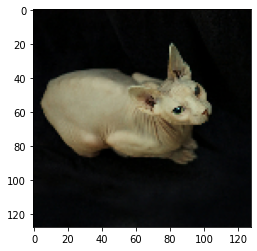

In [10]:
plt.imshow(image)

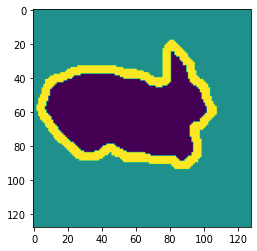

In [11]:
plt.imshow(mask)

In [13]:
np.unique(np.array(mask))

array([0., 1., 2.], dtype=float32)

In [14]:
BATCH_SIZE = 4
BUFFER_SIZE = 1000

train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(1000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(1000).take(669).batch(BATCH_SIZE)

In [18]:
print(train_batches)

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 128, 128, 1)), types: (tf.float32, tf.float32)>


In [62]:
from tensorflow.keras.utils import normalize
from keras.metrics import MeanIoU
import segmentation_models as sm

activation='softmax' #softmax/sigmoid
n_class = 3
LR = 0.00001
optim = tf.keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
#dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
dice_loss = sm.losses.DiceLoss(class_weights=np.array([.33,.33, .34])) 

focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

#metrics = [MeanIoU(num_classes=n_class)]

import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

BACKBONE1 = 'resnet34'#resnet34, inceptionv3, vgg16
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

# preprocess input
# X_train1 = preprocess_input1(X_train)
# X_val1 = preprocess_input1(X_val)

# define model

model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=n_class, activation=activation)

# compile keras model with defined optimozer, loss and metrics
# model1.compile(optimizer=tf.keras.optimizers.Adam(),
#                    loss="sparse_categorical_crossentropy",
#                    metrics="accuracy")

model1.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=metrics)

# print(model1.summary())



In [63]:
NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
TEST_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

history1 = model1.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches)

Epoch 1/20
920/920 [==============================] - 45s 45ms/step - loss: 0.4743 - iou_score: 0.2943 - f1-score: 0.3786 - val_loss: 0.7264 - val_iou_score: 0.2971 - val_f1-score: 0.3542
Epoch 2/20
920/920 [==============================] - 41s 44ms/step - loss: 0.3671 - iou_score: 0.3133 - f1-score: 0.4042 - val_loss: 0.3550 - val_iou_score: 0.3193 - val_f1-score: 0.4102
Epoch 3/20
920/920 [==============================] - 41s 44ms/step - loss: 0.3323 - iou_score: 0.3176 - f1-score: 0.4091 - val_loss: 0.4020 - val_iou_score: 0.3185 - val_f1-score: 0.3870
Epoch 4/20
920/920 [==============================] - 41s 44ms/step - loss: 0.3028 - iou_score: 0.3205 - f1-score: 0.4119 - val_loss: 0.3135 - val_iou_score: 0.3192 - val_f1-score: 0.4213
Epoch 5/20
920/920 [==============================] - 41s 45ms/step - loss: 0.2882 - iou_score: 0.3219 - f1-score: 0.4135 - val_loss: 0.3617 - val_iou_score: 0.3176 - val_f1-score: 0.4243
Epoch 6/20
920/920 [==============================] - 41s 45

In [64]:
def display_learning_curves(history):
    iou = history.history["iou_score"]
    val_iou = history.history["val_iou_score"]
    
    fscore = history.history["f1-score"]
    val_fscore = history.history["val_f1-score"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(NUM_EPOCHS)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,3,1)
    plt.plot(epochs_range, iou, label="train iou")
    plt.plot(epochs_range, val_iou, label="validataion iou")
    plt.title("IOU")
    plt.xlabel("Epoch")
    plt.ylabel("IOU")
    plt.legend(loc="lower right")
    
    plt.subplot(1,3,2)
    plt.plot(epochs_range, fscore, label="train f1-score")
    plt.plot(epochs_range, val_fscore, label="validataion f1-score")
    plt.title("F1-score")
    plt.xlabel("Epoch")
    plt.ylabel("F1-score")
    plt.legend(loc="upper right")

    plt.subplot(1,3,3)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

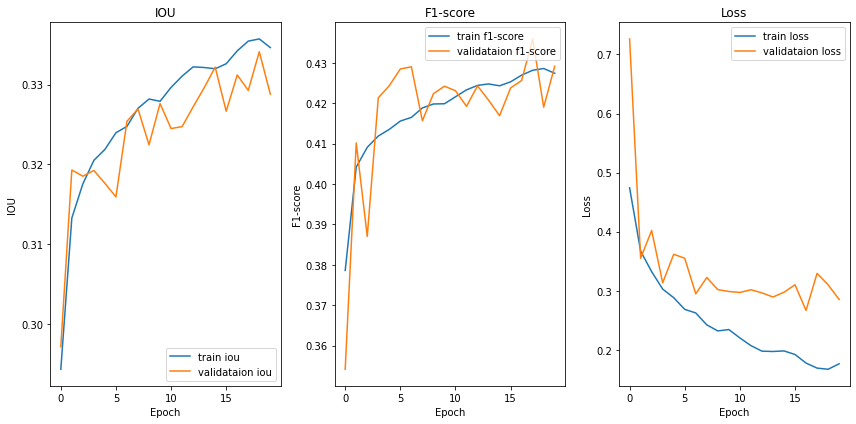

In [65]:
# Display learning curves 
display_learning_curves(history1)

In [66]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [76]:
count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

number of batches: 168


In [120]:
def show_predictions(dataset=None, num=1):
  im_array =[]
  mask_array = []
  pre_array = []  
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model1.predict(image)
      im_array.append(image[0])
      mask_array.append(mask[0])
      pred_mask = create_mask(pred_mask)
      pre_array.append(pred_mask)
  else:
    display([sample_image, sample_mask,
             create_mask(model1.predict(sample_image[tf.newaxis, ...]))])
    
  return im_array, mask_array, pre_array

In [121]:
im_array,mask_array, pre_array= show_predictions(test_batches.skip(5), 3)

In [122]:
pre_array[0].shape

TensorShape([128, 128, 1])

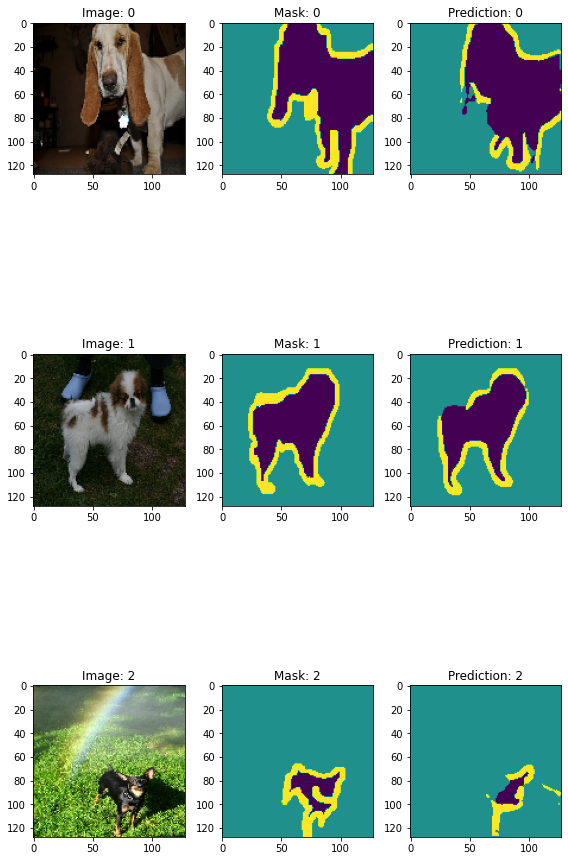

In [123]:
def visualize_image_mask_prediction_sample(image_dataset, mask_dataset, pred_dataset):
    n= len(image_dataset)
    rows=n
    cols=3
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(8,n*5) )
    c=0
    j=1
    for i in range(n):
        ax.ravel()[c].imshow(image_dataset[i])
        ax.ravel()[c].set_title("Image: "+str(i))
        ax.ravel()[c+1].imshow(mask_dataset[i])
        
        ax.ravel()[c+1].set_title("Mask: "+str(i))
        
        ax.ravel()[c+2].imshow(pred_dataset[i])
        ax.ravel()[c+2].set_title("Prediction: "+str(i))
        
        c=c+3
        j=j+1
    plt.tight_layout()
  
visualize_image_mask_prediction_sample(im_array,mask_array, pre_array)        